In [1]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image
import multiprocessing

## COLD ATOM

3.46e+16
3.46e+14


Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

Processing z step 2500/10000
Processing z step 5000/10000
Processing z step 7500/10000


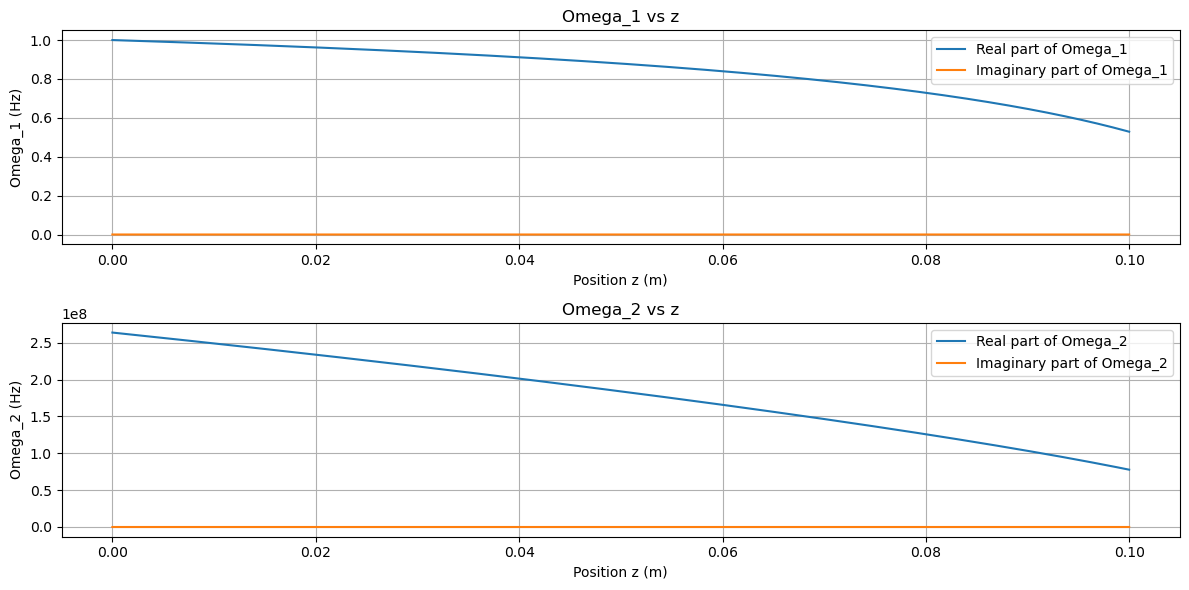

In [39]:
Transparency_Omega_1 = None
Transparency_Omega_2 = None
Om_2_list_adapted = None

# Constants
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
hbar = 1.054e-34       # Reduced Planck's constant (J·s)
mu_13 = mu_23 = 2.5377e-29      # Dipole moment between states (|1> and |3>) and (|1> and |3>) (C·m)

Gamma3 = 2 * np.pi * 6e6   # (Hz)
Gamma31 = 5/9 * Gamma3   # Decay from level 3 to level 1 (Hz)
Gamma32 = Gamma23 = 4/9 * Gamma3   # Decay from level 3 to level 2 (Hz)
Gamma12 = Gamma21 = 0.05 * Gamma3    # Decay rates between levels 1 and 2 (Hz)
gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (Hz)
gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (Hz)
gamma12 = (Gamma12 + Gamma21)/2     # Decoherence rate between ground states (Hz)

w_1 = 2 * np.pi * 3e8 / 795e-9
k_0 = w_1 / 3e8
L = 0.1        # Length in meters
z = 0.00001    # Step size in meters

OD_0 = 10
N1 = OD_0 / ((4 * np.pi * mu_13**2 * L) / (Gamma3 * hbar * epsilon_0 * 795e-9))
N = 3.46e16
print("{:.2e}".format(N))
print("{:.2e}".format(N1))

# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0):

    Om_2_list = 7 * Gamma3 + 0j
    Om_1_list = Om_1 * Gamma3 + 0j
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    # Initialize arrays to store rho31 and rho32
    rho31_values = np.zeros((nz), dtype=complex)
    rho32_values = np.zeros((nz), dtype=complex)

    for i in range(nz):
        if i == nz/4 or i == nz/2 or i == 3*nz/4: 
            print(f"Processing z step {i}/{nz}")
        
        Om_2_actual = Om_2_list      # Convert to actual Omega_2 in MHz
        Om_1_actual = Om_1_list      # Convert Om_1 to MHz

        delta_1_actual = delta_1 * Gamma3
        delta_2_actual = delta_2 * Gamma3

        # Construct A and b as per Code2
        # Define the imaginary unit
        I = 1j

        # Construct the matrix A
        A = np.array([
            # Row 1
            [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
            # Row 2
            [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
            # Row 3
            [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
            # Row 4
            [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
            # Row 5
            [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
            # Row 6
            [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
            # Row 7
            [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
            # Row 8
            [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
        ], dtype=complex)

        # Construct the vector b
        b = np.array([
            Gamma31,
            0,
            I*np.conjugate(Om_1_actual)/2,
            0,
            Gamma32,
            I*np.conjugate(Om_2_actual)/2,
            -I*Om_1_actual/2,
            -I*Om_2_actual/2
        ], dtype=complex)

        # Solve the linear system A * v = b
        try:
            v = np.linalg.solve(A, b)
        except np.linalg.LinAlgError:
            # Handle singular matrix
            print("nan")
            return [np.nan] * 8  # Return an array of NaNs

        # Extract the solutions
        rho11 = np.real(v[0])
        rho12 = v[1]
        rho13 = v[2]
        rho21 = v[3]
        rho22 = np.real(v[4])
        rho23 = v[5]
        rho31 = v[6]
        rho32 = v[7]

        # Compute rho33
        rho33 = 1 - rho11 - rho22

        # Update the Rabi frequencies
        Om_2_list = Om_2_actual + z * (1j) * (k_0 / (epsilon_0 * hbar)) * N * rho32 * mu_23**2
        Om_1_list = Om_1_actual + z * (1j) * (k_0 / (epsilon_0 * hbar)) * N * rho31 * mu_13**2

        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())
    
    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_vs_z, Om_1_vs_z, z_array

def plot_OD(Om_1: list,delta_1: list, delta_2):
    
    Om_2_vs_z, Om_1_vs_z, z_array = calculate_OD_1(Om_1, delta_1, delta_2)
    
    # Extract real and imaginary parts
    Om_1_real = np.real(Om_1_vs_z)
    Om_1_imag = np.imag(Om_1_vs_z)
    Om_2_real = np.real(Om_2_vs_z)
    Om_2_imag = np.imag(Om_2_vs_z)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot Omega_1
    plt.subplot(2, 1, 1)
    plt.plot(z_array, Om_1_real/(Om_1*Gamma3), label='Real part of Omega_1')
    plt.plot(z_array, Om_1_imag, label='Imaginary part of Omega_1')
    plt.xlabel('Position z (m)')
    plt.ylabel('Omega_1 (Hz)')
    plt.title('Omega_1 vs z')
    plt.legend()
    plt.grid(True)

    # Plot Omega_2
    plt.subplot(2, 1, 2)
    plt.plot(z_array, Om_2_real, label='Real part of Omega_2')
    plt.plot(z_array, Om_2_imag, label='Imaginary part of Omega_2')
    plt.xlabel('Position z (m)')
    plt.ylabel('Omega_2 (Hz)')
    plt.title('Omega_2 vs z')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_1 = 3
    delta_1 = 0
    delta_2 = 0
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)

## HOT ATOM

3.50e+16
5.72e+10
[-1.10832521e-02 -7.38883472e-03 -4.92588981e-03 -3.65408233e-03
 -3.05184892e-03 -2.31293821e-03 -1.74707057e-03 -1.50860684e-03
 -1.33787683e-03 -1.20043287e-03 -1.08319985e-03 -9.79613140e-04
 -8.85855999e-04 -7.99490844e-04 -7.18853606e-04 -6.42749227e-04
 -5.70283909e-04 -5.00766025e-04 -4.33644255e-04 -3.68467136e-04
 -3.04855521e-04 -2.42483131e-04 -1.81062318e-04 -1.20333242e-04
 -6.00553006e-05  0.00000000e+00  6.00553006e-05  1.20333242e-04
  1.81062318e-04  2.42483131e-04  3.04855521e-04  3.68467136e-04
  4.33644255e-04  5.00766025e-04  5.70283909e-04  6.42749227e-04
  7.18853606e-04  7.99490844e-04  8.85855999e-04  9.79613140e-04
  1.08319985e-03  1.20043287e-03  1.33787683e-03  1.50860684e-03
  1.74707057e-03  2.31293821e-03  3.05184892e-03  3.65408233e-03
  4.92588981e-03  7.38883472e-03  1.10832521e-02]
Total area under Maxwellian: 0.9927308297261263


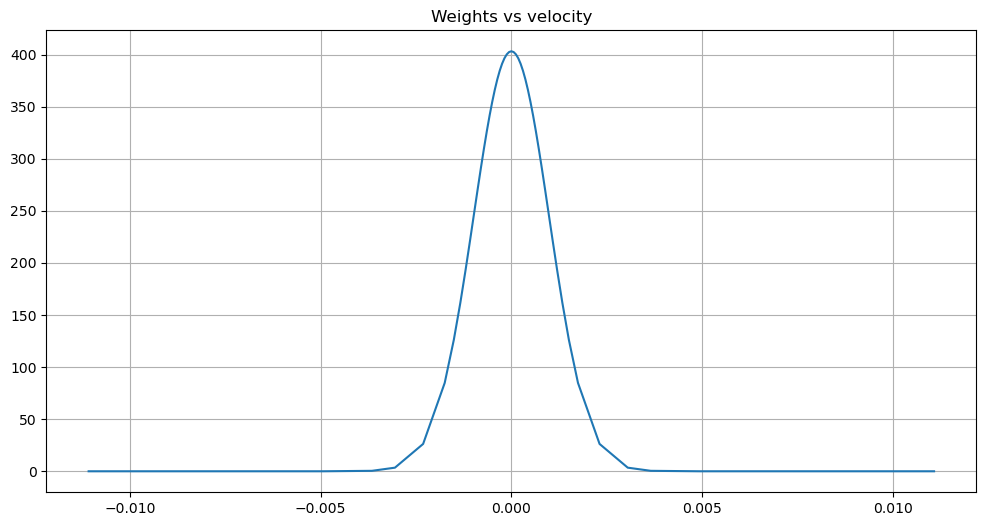

In [50]:
import numpy as np
from scipy.optimize import fsolve

# Constants
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
hbar = 1.054e-34       # Reduced Planck's constant (J·s)
mu_13 = mu_23 = 2.5377e-29      # Dipole moment between states (|1> and |3>) and (|1> and |3>) (C·m)
lambda1 = 795e-9       # In m
c = 3e8

Gamma3 = 2 * np.pi * 6e6   # (Hz)
Gamma31 = 5/9 * Gamma3   # Decay from level 3 to level 1 (Hz)
Gamma32 = Gamma23 = 4/9 * Gamma3   # Decay from level 3 to level 2 (Hz)
Gamma12 = Gamma21 = 0.05 * Gamma3    # Decay rates between levels 1 and 2 (Hz)
gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (Hz)
gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (Hz)
gamma12 = (Gamma12 + Gamma21)/2     # Decoherence rate between ground states (Hz)

w_1 = 2 * np.pi * c / lambda1
k_0 = w_1 / c
L = 0.1        # Length in meters
z = 0.0001    # Step size in meters

k_b = 1.380649e-23     # Boltzmann constant (m^2 kg s^-2 K^-1)
m = 1.41e-25           # Mass of the particle (kg)
T = 0.00000001                # Temperature (K)
N = 3.5e16
#OD_0 = N*L*((2 * np.pi)**2 * np.abs(mu_13)**2) / (hbar * epsilon_0 * w_1 * lambda1) * np.sqrt(m * c**2 / (2 * np.pi * k_b * T)) 

OD_0 = 10
N1 = OD_0 * (1 / (((2 * np.pi)**2 * np.abs(mu_13)**2) / (hbar * epsilon_0 * w_1 * lambda1) * np.sqrt(m * c**2 / (2 * np.pi * k_b * T)) * L))

print("{:.2e}".format(N))
print("{:.2e}".format(N1))

# Thermal velocity standard deviation (Sigma)
sigma = np.sqrt(k_b * T / m)

# Maxwell-Boltzmann distribution function
def Maxwellian(V):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-V**2 / (2 * sigma**2))

# Number of velocity points
nv = 51
v_values = np.zeros(nv)
dv = np.zeros(nv)
dv_min = 0.00003  # Minimum velocity increment

# Middle index (centered at zero velocity)
mid_index = nv // 2
v_values[mid_index] = 0
dv[mid_index] = dv_min * 2

# Area under Maxwellian at zero velocity
area = dv[mid_index] * Maxwellian(0)

# Compute positive velocities
for m in range(mid_index + 1, nv):
    v_end = v_values[m - 1] + dv[m - 1] / 2

    # Define the function to find the root of
    def func(V):
        return Maxwellian((V + v_end) / 2) * (V - v_end) - area

    # Initial guess for V
    V_guess = 1.5 * v_end if v_end != 0 else dv_min

    # Use fsolve to find V such that func(V) = 0
    V_solution = fsolve(func, V_guess)[0]

    # Update velocity and dv arrays
    v_values[m] = (V_solution + v_end) / 2
    dv[m] = V_solution - v_end

# Reflect to get negative velocities
v_values[:mid_index] = -np.flip(v_values[mid_index + 1:])
dv[:mid_index] = np.flip(dv[mid_index + 1:])

print(v_values)

# Maxwell-Boltzmann distribution weights
weights = Maxwellian(v_values)

# Verify that the total area under the curve approximates 1
total_area = np.sum(weights * dv)
print('Total area under Maxwellian:', total_area)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(v_values, weights)
plt.title('Weights vs velocity')
plt.grid(True)

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

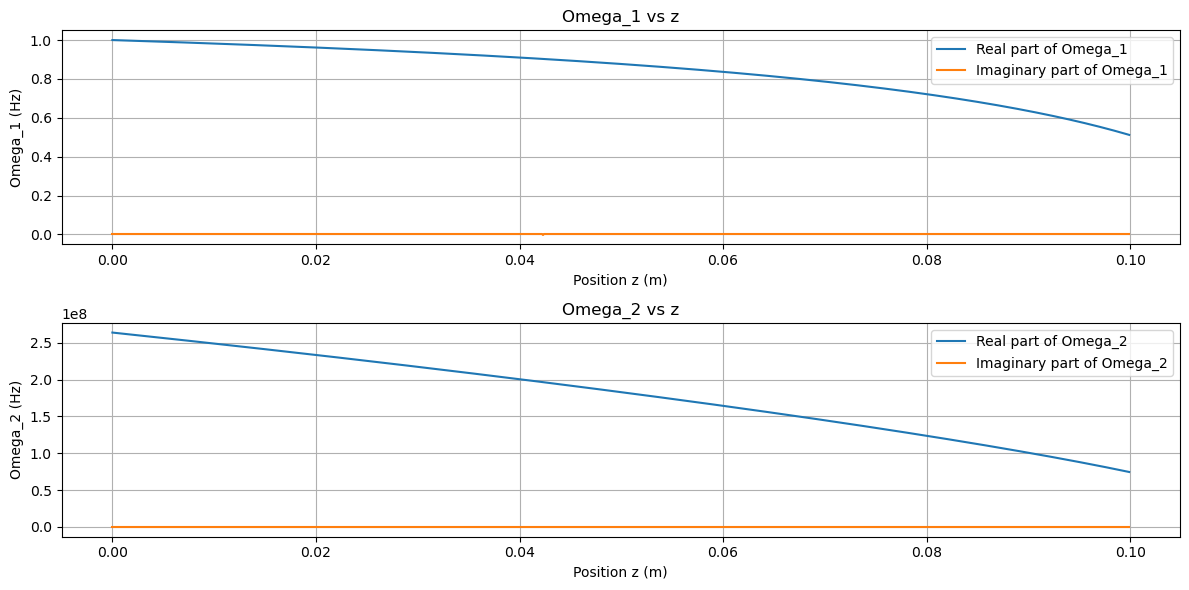

In [51]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 1
    Om_2_list = 7 * Gamma3 + 0j
    Om_1_list = Om_1 * Gamma3 + 0j
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    for i in range(nz):
        #if i == nz/4 or i == nz/2 or i == 3*nz/4: 
        #print(f"Processing z step {i}/{nz}")
            
        # Initialize arrays to store rho31 and rho32
        rho31_values = []
        rho32_values = []
        
        for k in range(len(v_values)):                   
            
            Om_2_actual = Om_2_list      # Convert to actual Omega_2 in Hz
            Om_1_actual = Om_1_list      # Convert Om_1 to Hz
            
            delta_1_actual = delta_1 * Gamma3 + k_0 * v_values[k]
            delta_2_actual = delta_2 * Gamma3 + k_0 * v_values[k]

            # Define the imaginary unit
            I = 1j

            # Construct the matrix A
            A = np.array([
                # Row 1
                [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                # Row 2
                [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                # Row 3
                [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                # Row 4
                [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                # Row 5
                [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                # Row 6
                [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                # Row 7
                [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                # Row 8
                [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
            ], dtype=complex)

            # Construct the vector b
            b = np.array([
                Gamma31,
                0,
                I*np.conjugate(Om_1_actual)/2,
                0,
                Gamma32,
                I*np.conjugate(Om_2_actual)/2,
                -I*Om_1_actual/2,
                -I*Om_2_actual/2
            ], dtype=complex)
            
            try:
                v = np.linalg.solve(A, b)
            except np.linalg.LinAlgError:
                # Handle singular matrix
                print(f"Singular matrix at z step {i}, velocity index {k}")
                rho31 = np.nan
                rho32 = np.nan
            else:
                # Extract the solutions
                rho11 = np.real(v[0])
                rho12 = v[1]
                rho13 = v[2]
                rho21 = v[3]
                rho22 = np.real(v[4])
                rho23 = v[5]
                rho31 = v[6]
                rho32 = v[7]

            # Compute rho33
            rho33 = 1 - rho11 - rho22

            # Store the populations
            rho31_values.append(rho31)
            rho32_values.append(rho32)  

        # Compute the weighted sums using dot product
        rho32_val = np.sum(rho32_values * weights * dv) / np.sum(weights * dv)
        rho31_val = np.sum(rho31_values * weights * dv) / np.sum(weights * dv)
                
        # Update the Rabi frequencies
        Om_2_list = Om_2_actual + z * (1j) * (k_0 / (epsilon_0 * hbar)) * N * rho32_val * mu_23**2
        Om_1_list = Om_1_actual + z * (1j) * (k_0 / (epsilon_0 * hbar)) * N * rho31_val * mu_13**2 
        
        #min_threshold = 1e-16  # Physically justified minimum value

        #if np.abs(Om_1_list) < min_threshold:
            #Om_1_list = min_threshold * np.exp(1j * np.angle(Om_1_list))
            #print(f"Om_1_list capped at step {i}")

        #if np.abs(Om_2_list) < min_threshold:
            #Om_2_list = min_threshold * np.exp(1j * np.angle(Om_2_list))
            #print(f"Om_2_list capped at step {i}")
        
        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())

    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_vs_z, Om_1_vs_z, z_array

def plot_OD(Om_1: list,delta_1: list, delta_2):
    
    Om_2_vs_z, Om_1_vs_z, z_array = calculate_OD_1(Om_1, delta_1, delta_2)
    
    # Extract real and imaginary parts
    Om_1_real = np.real(Om_1_vs_z)
    Om_1_imag = np.imag(Om_1_vs_z)
    Om_2_real = np.real(Om_2_vs_z)
    Om_2_imag = np.imag(Om_2_vs_z)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot Omega_1
    plt.subplot(2, 1, 1)
    plt.plot(z_array, Om_1_real/(Gamma3*Om_1), label='Real part of Omega_1')
    plt.plot(z_array, Om_1_imag, label='Imaginary part of Omega_1')
    plt.xlabel('Position z (m)')
    plt.ylabel('Omega_1 (Hz)')
    plt.title('Omega_1 vs z')
    plt.legend()
    plt.grid(True)

    # Plot Omega_2
    plt.subplot(2, 1, 2)
    plt.plot(z_array, Om_2_real, label='Real part of Omega_2')
    plt.plot(z_array, Om_2_imag, label='Imaginary part of Omega_2')
    plt.xlabel('Position z (m)')
    plt.ylabel('Omega_2 (Hz)')
    plt.title('Omega_2 vs z')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_1 = 3
    delta_1 = 0
    delta_2 = 0
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)


Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

Processing z step 0/1000
Processing z step 1/1000
Processing z step 2/1000
Processing z step 3/1000
Processing z step 4/1000
Processing z step 5/1000
Processing z step 6/1000
Processing z step 7/1000
Processing z step 8/1000
Processing z step 9/1000
Processing z step 10/1000
Processing z step 11/1000
Processing z step 12/1000
Processing z step 13/1000
Processing z step 14/1000
Processing z step 15/1000
Processing z step 16/1000
Processing z step 17/1000
Processing z step 18/1000
Processing z step 19/1000
Processing z step 20/1000
Processing z step 21/1000
Processing z step 22/1000
Processing z step 23/1000
Processing z step 24/1000
Processing z step 25/1000
Processing z step 26/1000
Processing z step 27/1000
Processing z step 28/1000
Processing z step 29/1000
Processing z step 30/1000
Processing z step 31/1000
Processing z step 32/1000
Processing z step 33/1000
Processing z step 34/1000
Processing z step 35/1000
Processing z step 36/1000
Processing z step 37/1000
Processing z step 38/1

Processing z step 356/1000
Processing z step 357/1000
Processing z step 358/1000
Processing z step 359/1000
Processing z step 360/1000
Processing z step 361/1000
Processing z step 362/1000
Processing z step 363/1000
Processing z step 364/1000
Processing z step 365/1000
Processing z step 366/1000
Processing z step 367/1000
Processing z step 368/1000
Processing z step 369/1000
Processing z step 370/1000
Processing z step 371/1000
Processing z step 372/1000
Processing z step 373/1000
Processing z step 374/1000
Processing z step 375/1000
Processing z step 376/1000
Processing z step 377/1000
Processing z step 378/1000
Processing z step 379/1000
Processing z step 380/1000
Processing z step 381/1000
Processing z step 382/1000
Processing z step 383/1000
Processing z step 384/1000
Processing z step 385/1000
Processing z step 386/1000
Processing z step 387/1000
Processing z step 388/1000
Processing z step 389/1000
Processing z step 390/1000
Processing z step 391/1000
Processing z step 392/1000
P

Processing z step 689/1000
Processing z step 690/1000
Processing z step 691/1000
Processing z step 692/1000
Processing z step 693/1000
Processing z step 694/1000
Processing z step 695/1000
Processing z step 696/1000
Processing z step 697/1000
Processing z step 698/1000
Processing z step 699/1000
Processing z step 700/1000
Processing z step 701/1000
Processing z step 702/1000
Processing z step 703/1000
Processing z step 704/1000
Processing z step 705/1000
Processing z step 706/1000
Processing z step 707/1000
Processing z step 708/1000
Processing z step 709/1000
Processing z step 710/1000
Processing z step 711/1000
Processing z step 712/1000
Processing z step 713/1000
Processing z step 714/1000
Processing z step 715/1000
Processing z step 716/1000
Processing z step 717/1000
Processing z step 718/1000
Processing z step 719/1000
Processing z step 720/1000
Processing z step 721/1000
Processing z step 722/1000
Processing z step 723/1000
Processing z step 724/1000
Processing z step 725/1000
P

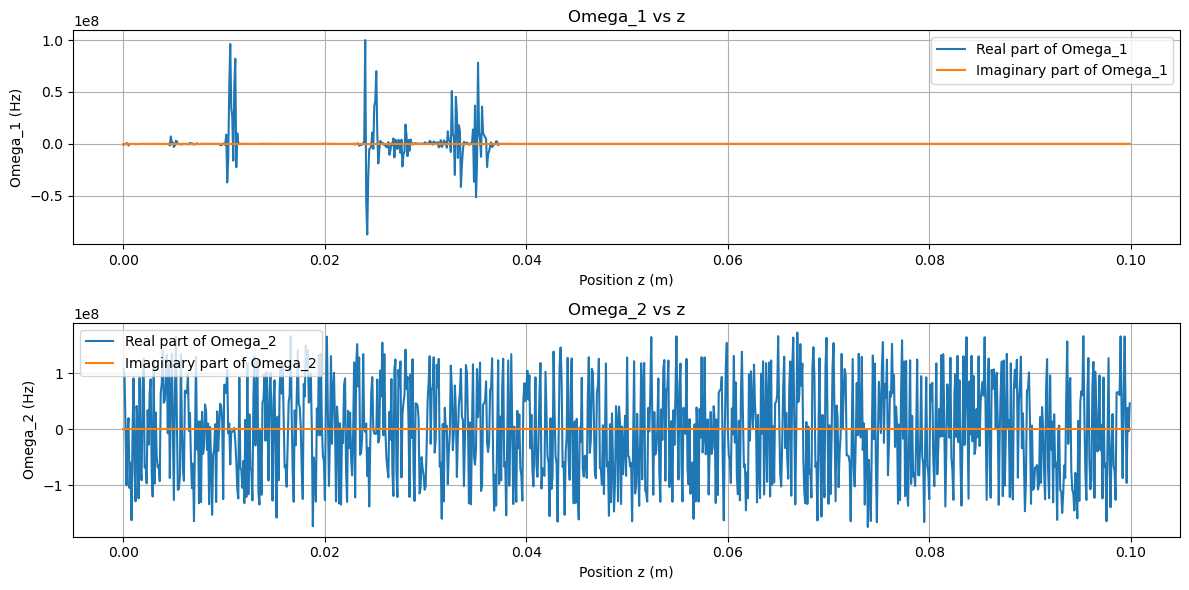

In [267]:
def compute_F1_F2(Om_1_input, Om_2_input, delta_1, delta_2):
    # Initialize arrays to store rho31 and rho32
    rho31_values = []
    rho32_values = []
    
    for k in range(len(v_values)):
        Om_1_actual = Om_1_input
        Om_2_actual = Om_2_input

        delta_1_actual = delta_1 * Gamma3 + k_0 * v_values[k] / (10**6)
        delta_2_actual = delta_2 * Gamma3 + k_0 * v_values[k] / (10**6)

        # Define the imaginary unit
        I = 1j

        # Construct the matrix A
        A = np.array([
            # Row 1
            [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
            # Row 2
            [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
            # Row 3
            [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
            # Row 4
            [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
            # Row 5
            [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
            # Row 6
            [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
            # Row 7
            [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
            # Row 8
            [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
        ], dtype=complex)

        # Construct the vector b
        b = np.array([
            Gamma31,
            0,
            I*np.conjugate(Om_1_actual)/2,
            0,
            Gamma32,
            I*np.conjugate(Om_2_actual)/2,
            -I*Om_1_actual/2,
            -I*Om_2_actual/2
        ], dtype=complex)

        # Solve the linear system A * v = b
        try:
            v = np.linalg.solve(A, b)
        except np.linalg.LinAlgError:
            # Handle singular matrix
            print("nan")
            return [np.nan] * 8  # Return an array of NaNs

        # Extract the solutions
        rho31 = v[6]
        rho32 = v[7]

        # Store the populations
        rho31_values.append(rho31)
        rho32_values.append(rho32)

    # Compute the weighted sums using dot product
    rho31_val = np.dot(rho31_values, weights)
    rho32_val = np.dot(rho32_values, weights)

    # Compute the derivatives
    F1 = (1j) * (k_0 / (epsilon_0 * hbar)) * N * rho31_val * mu_13**2
    F2 = (1j) * (k_0 / (epsilon_0 * hbar)) * N * rho32_val * mu_23**2

    return F1, F2

def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0):
    Om_2_current = 4 * Gamma3 + 0j
    Om_1_current = Om_1 * Gamma3 + 0j
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    for i in range(nz):
        print(f"Processing z step {i}/{nz}")
        
        # RK4 coefficients
        # k1
        F1_k1, F2_k1 = compute_F1_F2(Om_1_current, Om_2_current, delta_1, delta_2)
        k1_1 = F1_k1
        k1_2 = F2_k1

        # k2
        Om_1_k2 = Om_1_current + (z/2) * k1_1
        Om_2_k2 = Om_2_current + (z/2) * k1_2
        F1_k2, F2_k2 = compute_F1_F2(Om_1_k2, Om_2_k2, delta_1, delta_2)
        k2_1 = F1_k2
        k2_2 = F2_k2

        # k3
        Om_1_k3 = Om_1_current + (z/2) * k2_1
        Om_2_k3 = Om_2_current + (z/2) * k2_2
        F1_k3, F2_k3 = compute_F1_F2(Om_1_k3, Om_2_k3, delta_1, delta_2)
        k3_1 = F1_k3
        k3_2 = F2_k3

        # k4
        Om_1_k4 = Om_1_current + z * k3_1
        Om_2_k4 = Om_2_current + z * k3_2
        F1_k4, F2_k4 = compute_F1_F2(Om_1_k4, Om_2_k4, delta_1, delta_2)
        k4_1 = F1_k4
        k4_2 = F2_k4

        # Update the Rabi frequencies
        Om_1_next = Om_1_current + (z/6) * (k1_1 + 2*k2_1 + 2*k3_1 + k4_1)
        Om_2_next = Om_2_current + (z/6) * (k1_2 + 2*k2_2 + 2*k3_2 + k4_2)

        # Record Rabi frequencies at this z step
        Om_1_vs_z.append(Om_1_next)
        Om_2_vs_z.append(Om_2_next)

        # Prepare for next iteration
        Om_1_current = Om_1_next
        Om_2_current = Om_2_next

    # Convert lists to numpy arrays
    Om_1_vs_z = np.array(Om_1_vs_z)
    Om_2_vs_z = np.array(Om_2_vs_z)
    
    return Om_2_vs_z, Om_1_vs_z, z_array

def plot_OD(Om_1: list,delta_1: list, delta_2):
    
    Om_2_vs_z, Om_1_vs_z, z_array = calculate_OD_1(Om_1, delta_1, delta_2)
    
    # Extract real and imaginary parts
    Om_1_real = np.real(Om_1_vs_z)
    Om_1_imag = np.imag(Om_1_vs_z)
    Om_2_real = np.real(Om_2_vs_z)
    Om_2_imag = np.imag(Om_2_vs_z)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot Omega_1
    plt.subplot(2, 1, 1)
    plt.plot(z_array, Om_1_real, label='Real part of Omega_1')
    plt.plot(z_array, Om_1_imag, label='Imaginary part of Omega_1')
    plt.xlabel('Position z (m)')
    plt.ylabel('Omega_1 (Hz)')
    plt.title('Omega_1 vs z')
    plt.legend()
    plt.grid(True)

    # Plot Omega_2
    plt.subplot(2, 1, 2)
    plt.plot(z_array, Om_2_real, label='Real part of Omega_2')
    plt.plot(z_array, Om_2_imag, label='Imaginary part of Omega_2')
    plt.xlabel('Position z (m)')
    plt.ylabel('Omega_2 (Hz)')
    plt.title('Omega_2 vs z')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_1 = 0.01
    delta_1 = 0
    delta_2 = 0
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)